In [3]:
#Build a classifier to predict the condition of a water well,  
#The stakeholder is the Tanzanian government that wants to see what determines if a well if function or not 

In [4]:
#Loading packages 

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer

import pickle

import warnings
warnings.filterwarnings('ignore')

In [5]:
#read in the test values data and set id as the index
test_value_df = pd.read_csv("/Users/arun/Desktop/Flatiron/Projects/Phase3_Project/Test_set_values.csv", index_col = 0)

In [6]:
#read in the training values data and set id as the index
training_value_df = pd.read_csv('/Users/arun/Desktop/Flatiron/Projects/Phase3_Project/Training_set_values.csv', index_col = 0)

#read in the training labels data and set id as the index
training_label_df = pd.read_csv('/Users/arun/Desktop/Flatiron/Projects/Phase3_Project/Training_set_labels.csv', index_col = 0)

#combine the training datasets
training_df = pd.concat([training_value_df, training_label_df], axis=1)

# EDA

In [7]:
#big range in values for construction year, population
#possible outliers in amount_tsh and big range in population and construction year.
#Multiple columns have 0 as a value.

training_df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [8]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15

In [9]:
#look for null values in the dataset
training_df.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [10]:
#Count number of zeros in all columns of Dataframe
#significant amount of zeros in multiple columns.

#amount_tsh will need some sort of imputing 
#construction year has no NA values but does have over 20K zero values.

for column_name in training_df.columns:
    column = training_df[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    print('Count of zeros in column in', column_name, ' is : ', count)

Count of zeros in column in amount_tsh  is :  41639
Count of zeros in column in date_recorded  is :  0
Count of zeros in column in funder  is :  0
Count of zeros in column in gps_height  is :  20438
Count of zeros in column in installer  is :  0
Count of zeros in column in longitude  is :  1812
Count of zeros in column in latitude  is :  0
Count of zeros in column in wpt_name  is :  0
Count of zeros in column in num_private  is :  58643
Count of zeros in column in basin  is :  0
Count of zeros in column in subvillage  is :  0
Count of zeros in column in region  is :  0
Count of zeros in column in region_code  is :  0
Count of zeros in column in district_code  is :  23
Count of zeros in column in lga  is :  0
Count of zeros in column in ward  is :  0
Count of zeros in column in population  is :  21381
Count of zeros in column in public_meeting  is :  5055
Count of zeros in column in recorded_by  is :  0
Count of zeros in column in scheme_management  is :  0
Count of zeros in column in s

In [11]:
#There are 6 different variables for Geographic location not including Long/Lat.

print('region count:' ,len(training_df['region'].unique()))

#region code count has more categories then region count
print('region code count:', len(training_df['region_code'].unique()))

#district code has 23 0 values but still might be better to use because of numerical values
print('district code count:', len(training_df['district_code'].unique()))

region count: 21
region code count: 27
district code count: 20


In [12]:
#scheme_management and scheme_name are data for who operates the waterpoint
#Scheme_name has alot more None values

print('scheme_management:' ,len(training_df['scheme_management'].unique()))
print(training_df['scheme_management'].value_counts())

print('----------------------------------------------')

print('scheme_name:' ,len(training_df['scheme_name'].unique()))
print(training_df['scheme_name'].value_counts())

scheme_management: 13
VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64
----------------------------------------------
scheme_name: 2697
K                               682
None                            644
Borehole                        546
Chalinze wate                   405
M                               400
                               ... 
Pareni Water Supply               1
Ngiresi  pipe line                1
Maswa Water supplier supply       1
Nambehe water Gravity scheme      1
Mlingotini wa                     1
Name: scheme_name, Length: 2696, dtype: int64


In [13]:
#extraction_type, extraction_type_group and extraction_type_class seem very similar as well
#They all have no null values and don't contain 0 as a value 
#going to use just extraction_type since it has the most categories

print('extraction_type:' ,len(training_df['extraction_type'].unique()))
print(training_df['extraction_type'].value_counts())
print('----------------------------------------------')
print('extraction_type_group:' ,len(training_df['extraction_type_group'].unique()))
print(training_df['extraction_type_group'].value_counts())
print('----------------------------------------------')
print('extraction_type_class:' ,len(training_df['extraction_type_class'].unique()))
print(training_df['extraction_type_class'].value_counts())

extraction_type: 18
gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64
----------------------------------------------
extraction_type_group: 13
gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump  

In [14]:
#how the waterpoint is managed also has similar data
#going to use management

print('management:' ,len(training_df['management'].unique()))
print(training_df['management'].value_counts())
print('----------------------------------------------')
print('management_group:' ,len(training_df['management_group'].unique()))
print(training_df['management_group'].value_counts())

management: 12
vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64
----------------------------------------------
management_group: 5
user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64


In [15]:
#payment has 2 variables as well, seem identical

print('payment:' ,len(training_df['payment'].unique()))
print(training_df['payment'].value_counts())
print('--------------------------------------------------------')
print('payment_type:' ,len(training_df['payment_type'].unique()))
print(training_df['payment_type'].value_counts())

payment: 7
never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64
--------------------------------------------------------
payment_type: 7
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64


In [16]:
#water quality also has 2 variables
#going to use quality_group

print('water_quality:' ,len(training_df['water_quality'].unique()))
print(training_df['water_quality'].value_counts())
print('----------------------------------------------')
print('quality_group:' ,len(training_df['quality_group'].unique()))
print(training_df['quality_group'].value_counts())

water_quality: 8
soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64
----------------------------------------------
quality_group: 6
good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64


In [17]:
#water quantity also has 2 variables
#identical, will use quantity 

print('quantity:' ,len(training_df['quantity'].unique()))
print(training_df['quantity'].value_counts())
print('----------------------------------------------')
print('quantity_group :' ,len(training_df['quantity_group'].unique()))
print(training_df['quantity_group'].value_counts())

quantity: 5
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64
----------------------------------------------
quantity_group : 5
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64


In [18]:
#there are 3 varaibles for water source
#going to use source, less unknowns and more granular categories

print('source:' ,len(training_df['source'].unique()))
print(training_df['source'].value_counts())
print('----------------------------------------------')
print('source_type:' ,len(training_df['source_type'].unique()))
print(training_df['source_type'].value_counts())
print('----------------------------------------------')
print('source_class:' ,len(training_df['source_class'].unique()))
print(training_df['source_class'].value_counts())

source: 10
spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64
----------------------------------------------
source_type: 7
spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64
----------------------------------------------
source_class: 3
groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64


In [19]:
#waterpoint also has 2 variables
#seems very redundant 

print('waterpoint_type' ,len(training_df['waterpoint_type'].unique()))
print(training_df['waterpoint_type'].value_counts())
print('----------------------------------------------')
print('waterpoint_type_group:' ,len(training_df['waterpoint_type_group'].unique()))
print(training_df['waterpoint_type_group'].value_counts())

waterpoint_type 7
communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64
----------------------------------------------
waterpoint_type_group: 6
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64


In [20]:
#this column has spelling errors and redundant data
#for exmaple FIN WATER, FinW, Fini water, FINI WATER are all considered unique because python is case sensative
#going to need to fix spelling mistakes, then transform them all to lowercase 

pd.set_option("display.max_rows", None)
training_df['installer'].value_counts()

DWE                               17402
Government                         1825
RWE                                1206
Commu                              1060
DANIDA                             1050
KKKT                                898
Hesawa                              840
0                                   777
TCRS                                707
Central government                  622
CES                                 610
Community                           553
DANID                               552
District Council                    551
HESAWA                              539
LGA                                 408
World vision                        408
WEDECO                              397
TASAF                               396
District council                    392
Gover                               383
AMREF                               329
TWESA                               316
WU                                  301
Dmdd                                287


In [21]:
#since the column has 0 as a value, first replace 0 with unknown
training_df['installer'].replace(to_replace = '0', value ='unknown' , inplace=True)

#have to also fill NAN values with unknown
training_df['installer'].fillna(value='unknown',inplace=True)

#begin replacing misspelled values
training_df['installer'].replace(to_replace = ('District Water Department', 'District water depar','Distric Water Department',
                                               'dwe'), value ='district water department' , inplace=True)

training_df['installer'].replace(to_replace = ('FinW','Fini water','FINI WATER'), value ='fini water' , inplace=True)

training_df['installer'].replace(to_replace = 'JAICA', value ='jaica' , inplace=True)

training_df['installer'].replace(to_replace = ('COUN', 'District COUNCIL', 'DISTRICT COUNCIL','District Counci', 
                                               'District Council','Council','Counc','District  Council','Distri'),
                                                value ='District council' , inplace=True)

training_df['installer'].replace(to_replace = ('RC CHURCH', 'RC Churc', 'RC','RC Ch','RC C', 'RC CH','RC church', 
                                               'RC CATHORIC',) , value ='RC Church' , inplace=True)

training_df['installer'].replace(to_replace = ('Central Government','Tanzania Government','central government',
                                            'Cental Government', 'Cebtral Government', 'Tanzanian Government',
                                            'Tanzania government', 'Centra Government','CENTRAL GOVERNMENT', 
                                            'TANZANIAN GOVERNMENT','Central govt','Centr','Centra govt', 
                                            'government','GOVERNMENT', 'GOVER', 'GOVERNME', 'GOVERM','GOVERN','Gover',
                                            'Gove','Governme','Governmen'),value ='Central government',inplace=True)

training_df['installer'].replace(to_replace = ('World vision', 'World Division','World Vision'),
                                                value ='world vision' , inplace=True)

training_df['installer'].replace(to_replace = ('Unisef','UNICEF'),value ='Unicef' , inplace=True)
training_df['installer'].replace(to_replace = 'DANID', value ='DANIDA' , inplace=True)

training_df['installer'].replace(to_replace = ('villigers', 'villager', 'Villagers', 'Villa', 'Village', 'Villi', 
                                               'Village Council','Village Counil', 'Villages', 'Vill', 
                                               'Village community','Villaers', 'Village Community', 'Villag',
                                               'Villege Council', 'Village council','Village  Council','Villagerd', 
                                               'Villager', 'Village Technician','Village Office',
                                               'Village community members'),value ='villagers' , inplace=True)

training_df['installer'].replace(to_replace =('Commu','Communit','commu','COMMU', 'COMMUNITY') ,
                                        value ='Community' , inplace=True)

training_df['installer'].replace(to_replace = 'Hesawa' ,value ='HESAWA' , inplace=True)

#now make all the values lower case. This looks much better.
training_df['installer'] = training_df['installer'].apply(str.lower)
training_df['installer'].value_counts().head(15)

#keeping only categories that have atleast 50 values 
keep = training_df['installer'].value_counts()[training_df['installer'].value_counts() > 50].index.values.tolist()

training_df = training_df.loc[training_df['installer'].isin(keep)]

In [22]:
#going to treat funder like installer
pd.set_option("display.max_rows", None)
training_df['funder'].value_counts()

Government Of Tanzania            8872
Danida                            3091
Hesawa                            2172
Rwssp                             1332
Kkkt                              1242
World Vision                      1045
Unicef                            1032
Dhv                                827
District Council                   826
Dwsp                               807
0                                  777
Tasaf                              770
Norad                              758
World Bank                         708
Private Individual                 613
Germany Republi                    610
Tcrs                               596
Water                              544
Ministry Of Water                  532
Dwe                                472
Netherlands                        467
Hifab                              450
Lga                                440
Amref                              425
Fini Water                         393
Adb                      

In [23]:
#since the column has 0 as a value, first replace 0 with unknown
training_df['funder'].replace(to_replace = '0', value ='unknown' , inplace=True)

#have to also fill NAN values with unknown
training_df['funder'].fillna(value='unknown',inplace=True)

#begin replacing misspelled values
training_df['funder'].replace(to_replace = ('District Water Department', 'District water depar','Distric Water Department',
                                            'dwe'),value ='district water department' , inplace=True)

training_df['funder'].replace(to_replace = ('FinW','Fini water','FINI WATER'), value ='fini water' , inplace=True)

training_df['funder'].replace(to_replace = 'JAICA', value ='jaica' , inplace=True)

training_df['funder'].replace(to_replace = ('COUN', 'District COUNCIL', 'DISTRICT COUNCIL','District Counci', 
                                            'District Council','Council','Counc','District  Council','Distri'),
                                            value ='District council' , inplace=True)

training_df['funder'].replace(to_replace = ('RC CHURCH', 'RC Churc', 'RC','RC Ch','RC C', 'RC CH','RC church', 
                                            'RC CATHORIC',) , value ='RC Church' , inplace=True)

training_df['funder'].replace(to_replace = ('Central Government','Tanzania Government','central government',
                                            'Cental Government', 'Cebtral Government', 'Tanzanian Government',
                                            'Tanzania government', 'Centra Government','CENTRAL GOVERNMENT', 
                                            'TANZANIAN GOVERNMENT','Central govt','Centr','Centra govt', 
                                            'government','GOVERNMENT', 'GOVER', 'GOVERNME', 'GOVERM','GOVERN','Gover',
                                            'Gove','Governme','Governmen'),value ='Central government',inplace=True)

training_df['funder'].replace(to_replace = ('World vision', 'World Division','World Vision'),
                                             value ='world vision' , inplace=True)

training_df['funder'].replace(to_replace = ('Unisef','UNICEF'),value ='Unicef' , inplace=True)

training_df['funder'].replace(to_replace = 'DANID', value ='DANIDA' , inplace=True)

training_df['funder'].replace(to_replace = ('villigers', 'villager', 'Villagers', 'Villa', 'Village', 'Villi', 
                                            'Village Council','Village Counil', 'Villages', 'Vill', 
                                            'Village community','Villaers', 'Village Community', 'Villag',
                                            'Villege Council','Village council','Village  Council','Villagerd', 
                                            'Villager', 'Village Technician','Village Office',
                                            'Village community members'), value ='villagers' , inplace=True)

training_df['funder'].replace(to_replace =('Commu','Communit','commu','COMMU', 'COMMUNITY') ,
                                            value ='Community' , inplace=True)

training_df['funder'].replace(to_replace = 'Hesawa' ,value ='HESAWA' , inplace=True)


#now make all the values lower case. This looks much better.
training_df['funder'] = training_df['funder'].apply(str.lower)
training_df['funder'].value_counts().head(20)

keep_funder = training_df['funder'].value_counts()[training_df['funder'].value_counts() > 50].index.values.tolist()

training_df = training_df.loc[training_df['funder'].isin(keep_funder)]

In [24]:
#columns to keep for a cleaner dataset. Dropped columns that either had redundant data, or many null/0 values.
#Continue the EDA process by seeing relationships between categories and status_group 

keep_columns = ['status_group','amount_tsh','installer','funder','longitude','latitude',
                'basin','region','region_code','district_code','scheme_management','extraction_type','management',
                'payment','quality_group','quantity','source','waterpoint_type','population','construction_year']
                
df = training_df[keep_columns]

[Text(0.5, 1.0, 'Water Pump Status')]

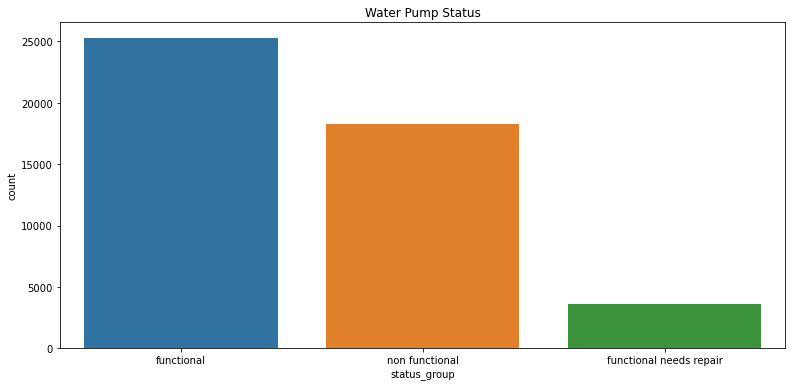

In [25]:
#The target variable is status_group. Imbalance in the target variable, going to need SMOTE to 
#bring data into balance

#54.30% of the pumps are funtional
#38.42% of the pumps are non functional
#7.26% of the pumps need repair

plt.figure(figsize=(13,6))
sns.countplot(df.status_group).set(title='Water Pump Status')

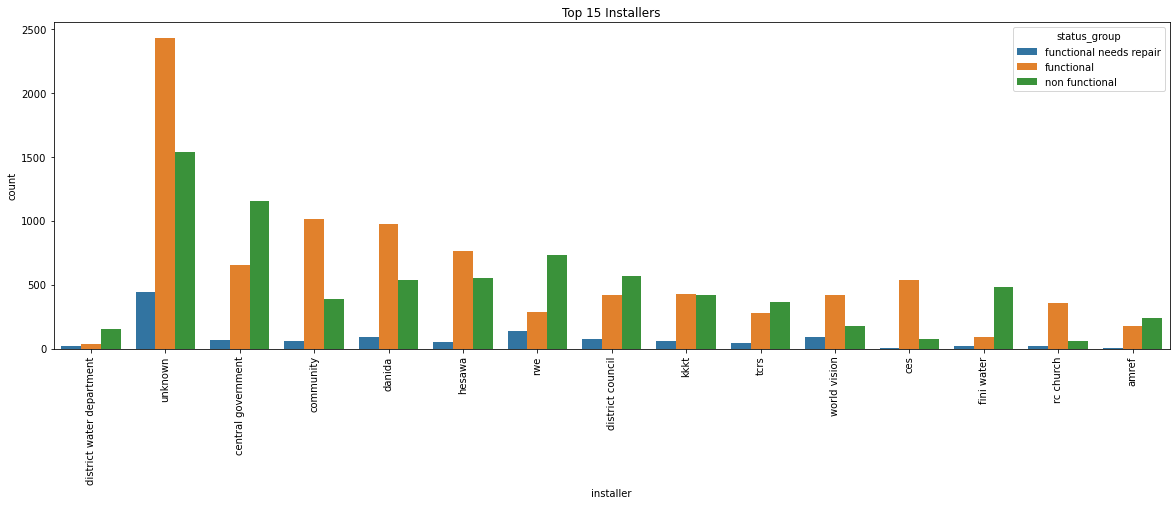

In [26]:
#A gragh of all installers isn't practical becasue there is too much data. Better to look at the top 20.

dfDwe = df.loc[df['installer']== 'district water department']
dfUnk = df.loc[df['installer']== 'unknown']              
dfCenGov = df.loc[df['installer']== 'central government'] 
dfCom = df.loc[df['installer']== 'community'] 
dfDan = df.loc[df['installer']== 'danida'] 
dfHes = df.loc[df['installer']== 'hesawa'] 
dfRwe = df.loc[df['installer']== 'rwe']
dfDc = df.loc[df['installer']== 'district council'] 
dfKkkt = df.loc[df['installer']== 'kkkt']  
dfTcr = df.loc[df['installer']== 'tcrs'] 
dfWor = df.loc[df['installer']== 'world vision'] 
dfCes = df.loc[df['installer']== 'ces'] 
dfFin = df.loc[df['installer']== 'fini water'] 
dfRc = df.loc[df['installer']== 'rc church'] 
dfAmr = df.loc[df['installer']== 'amref']

df_installer = pd.concat([dfDwe,dfUnk,dfCenGov,dfCom,dfDan,dfHes,dfRwe,dfDc,dfKkkt,dfTcr,dfWor,
                          dfCes,dfFin,dfRc,dfAmr], ignore_index=True)

#graph for the top 20 installers. governments and community wells good indicators for non-functioning wells.
plt.figure(figsize=(20,6))
sns.countplot(data=df_installer,x='installer',hue='status_group').set(title='Top 15 Installers')
plt.xticks(rotation=90)
plt.show()

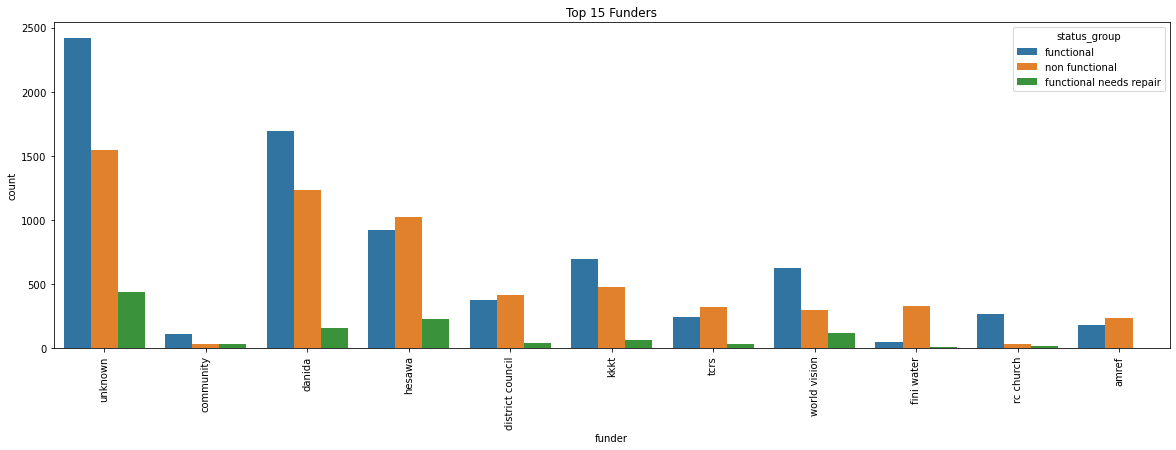

In [24]:
#treat funder the same as installer. Graph the top 15 to see if/how funder effects well functioning wells

dfDwe = df.loc[df['funder']== 'district water department']
dfUnk = df.loc[df['funder']== 'unknown']              
dfCenGov = df.loc[df['funder']== 'central government'] 
dfCom = df.loc[df['funder']== 'community'] 
dfDan = df.loc[df['funder']== 'danida'] 
dfHes = df.loc[df['funder']== 'hesawa'] 
dfRwe = df.loc[df['funder']== 'rwe']
dfDc = df.loc[df['funder']== 'district council'] 
dfKkkt = df.loc[df['funder']== 'kkkt']  
dfTcr = df.loc[df['funder']== 'tcrs'] 
dfWor = df.loc[df['funder']== 'world vision'] 
dfCes = df.loc[df['funder']== 'ces'] 
dfFin = df.loc[df['funder']== 'fini water'] 
dfRc = df.loc[df['funder']== 'rc church'] 
dfAmr = df.loc[df['funder']== 'amref']

df_funder = pd.concat([dfDwe,dfUnk,dfCenGov,dfCom,dfDan,dfHes,dfDc,dfKkkt,dfTcr,dfWor,
                          dfCes,dfFin,dfRc,dfAmr], ignore_index=True)

#graph for the top 20 installers. governments and community wells good indicators for non-functioning wells.
plt.figure(figsize=(20,6))
sns.countplot(data=df_funder,x='funder',hue='status_group').set(title='Top 15 Funders')
plt.xticks(rotation=90)
plt.show()

[Text(0.5, 1.0, 'Basin')]

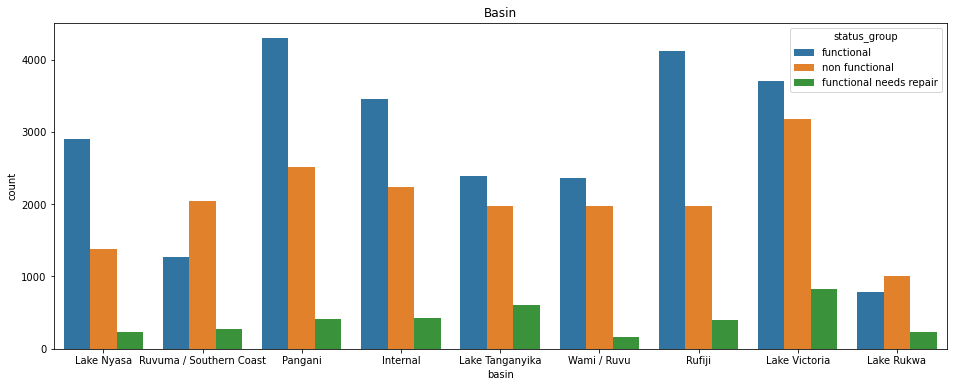

In [25]:
#All categories of basins show us good classification of various well types.
#For example, Pangani and Rufji are great for funtional 
#Ruvuma and Lake Rukwa are good for classification of non-funtional wells

plt.figure(figsize=(16,6))
sns.countplot(data=df,x='basin',hue='status_group').set(title='Basin')

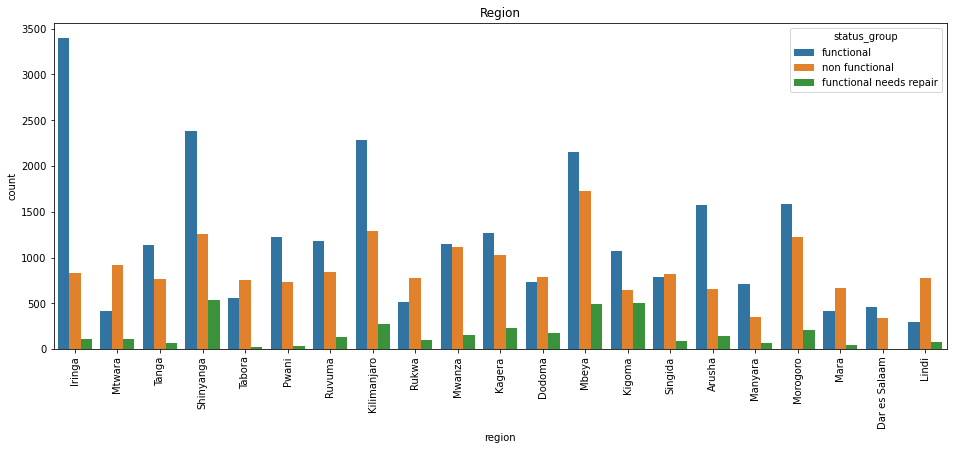

In [26]:
#disparities between regions for functioning water pumps.
plt.figure(figsize=(16,6))
sns.countplot(data=df,x='region',hue='status_group').set(title='Region')
plt.xticks(rotation=90)
plt.show()

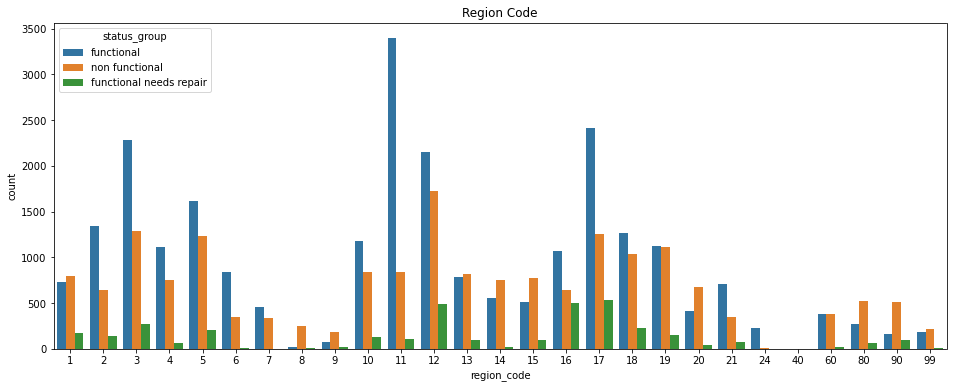

In [27]:
#disparities between region codes for functioning water pumps.
plt.figure(figsize=(16,6))
sns.countplot(data=df,x='region_code',hue='status_group').set(title='Region Code')
plt.show()

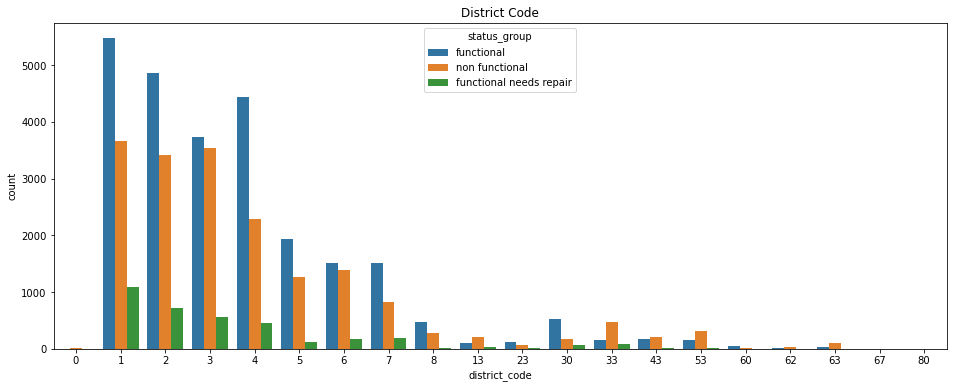

In [28]:
#disparities between district codes for functioning water pumps.
plt.figure(figsize=(16,6))
sns.countplot(data=df,x='district_code',hue='status_group').set(title='District Code')
plt.show()

[Text(0.5, 1.0, 'Payment Type')]

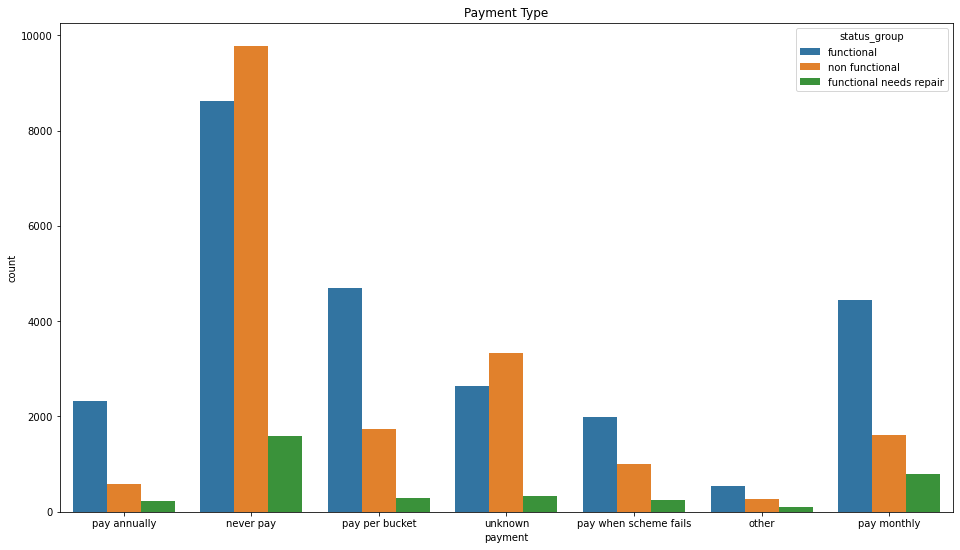

In [29]:
#payment doesn't seem to effect whether a pump is funtioning or not
plt.figure(figsize=(16, 9))
sns.countplot(data=df,x='payment',hue='status_group').set(title='Payment Type')

[Text(0.5, 1.0, 'Water Quality')]

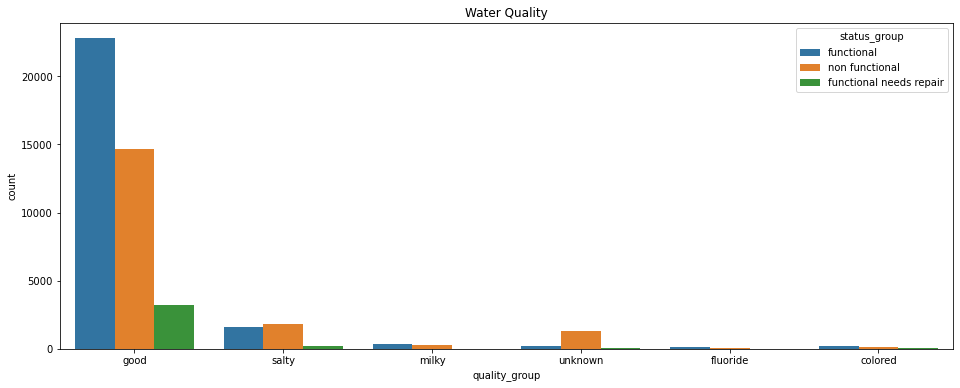

In [30]:
#Good water quality leads to more funtional wells as can be expeced. Salty water is good for classifying 
#non-functional wells

plt.figure(figsize=(16,6))
sns.countplot(data=df,x='quality_group',hue='status_group').set(title='Water Quality')

[Text(0.5, 1.0, 'Water Quantity')]

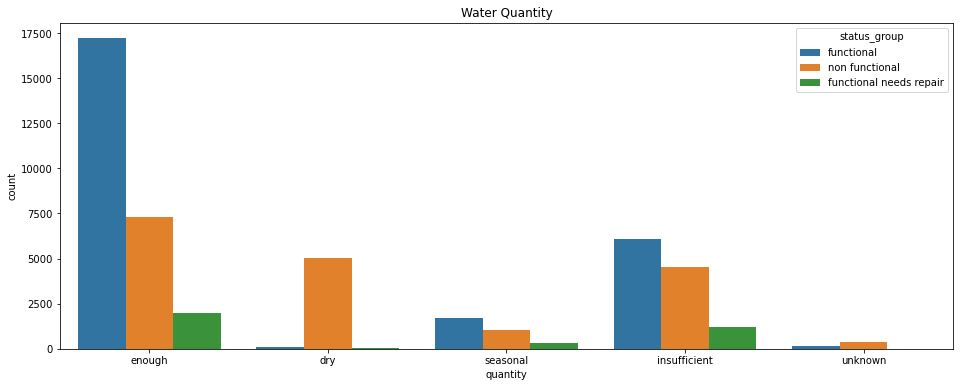

In [31]:
#Dry and insufficient water quantity leads to high non funtional wells 
plt.figure(figsize=(16,6))
sns.countplot(data=df,x='quantity',hue='status_group').set(title='Water Quantity')

[Text(0.5, 1.0, 'Water Source')]

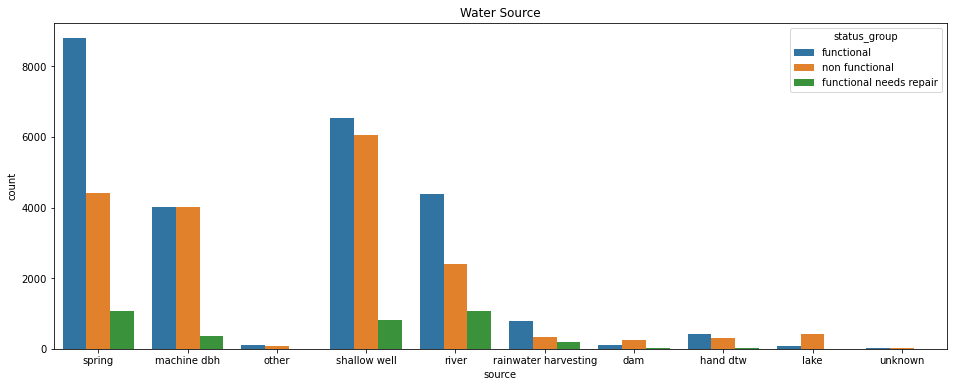

In [32]:
#spring are good classifiers for functional wells. Machine and shallow are good for non-funtional
plt.figure(figsize=(16,6))
sns.countplot(data=df,x='source',hue='status_group').set(title='Water Source')

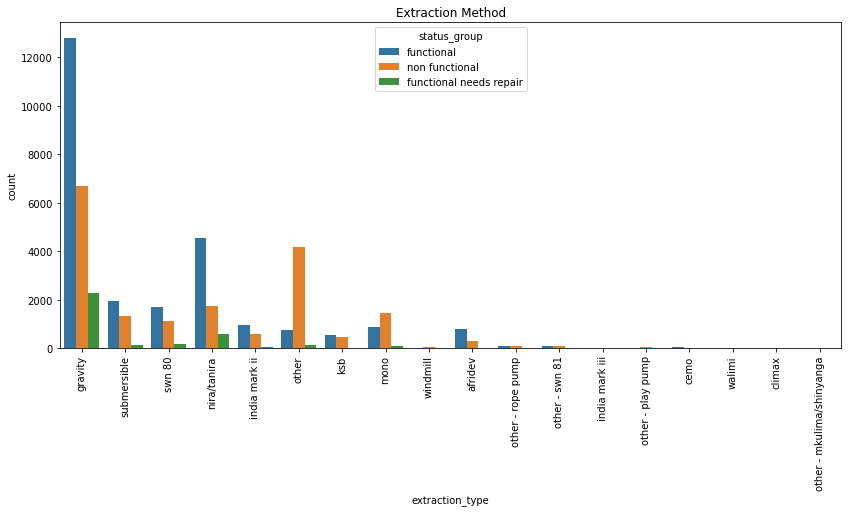

In [33]:
#gravity is responsible for the majority or working water pumps. Would need more data to find out 
#what other means as it has good predictive power for non-funtional wells.

plt.figure(figsize=(14,6))
my_plot = sns.countplot(data=df,x='extraction_type',hue='status_group').set(title='Extraction Method')
plt.xticks(rotation=90)
plt.show()

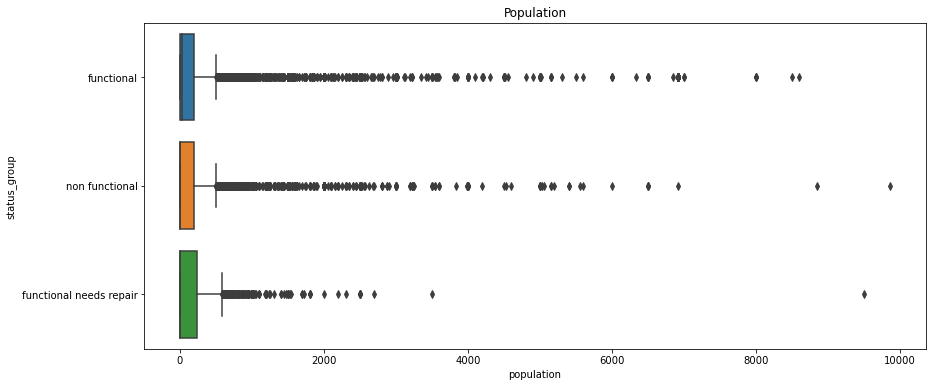

In [34]:
#As expeced funtioning wells have higher populations.
df = df.loc[df["population"] <= 10000 ]
plt.figure(figsize=(14,6))
my_plot = sns.boxplot(data=df,x='population',y='status_group').set(title='Population')
plt.show()

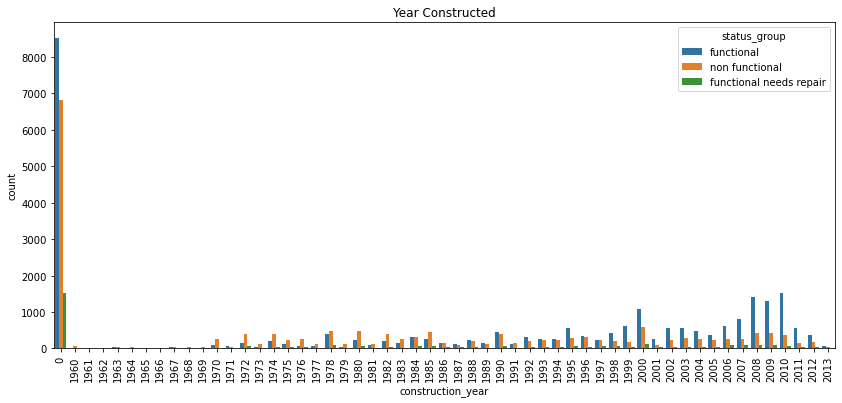

In [35]:
#hard to get any data from this plot because there is too much data. would be better to divide the years into 
#equal parts and graph it again.
plt.figure(figsize=(14,6))
my_plot = sns.countplot(data=df,x='construction_year',hue='status_group').set(title='Year Constructed')
plt.xticks(rotation=90)
plt.show()

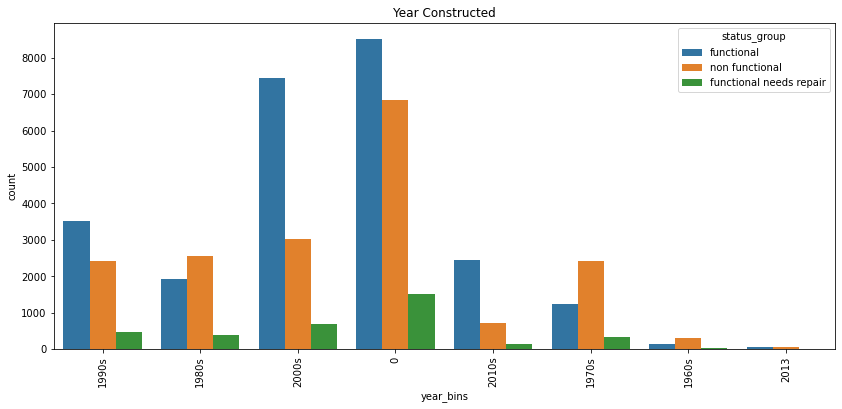

In [36]:
#divide the years by decades, I'm leaving 0 values inplace, this could be a suggestion of the 
#importance of data collecting going forwards.

df['year_bins'] = df['construction_year']

df['year_bins'].replace(to_replace = range(1960,1970),value ='1960s', inplace=True)
df['year_bins'].replace(to_replace = range(1970,1980),value ='1970s', inplace=True)
df['year_bins'].replace(to_replace = range(1980,1990),value ='1980s', inplace=True)
df['year_bins'].replace(to_replace = range(1990,2000),value ='1990s', inplace=True)
df['year_bins'].replace(to_replace = range(2000,2010),value ='2000s', inplace=True)
df['year_bins'].replace(to_replace = range(2000,2013),value ='2010s', inplace=True)

plt.figure(figsize=(14,6))
my_plot = sns.countplot(data=df,x='year_bins',hue='status_group').set(title='Year Constructed')
plt.xticks(rotation=90)
plt.show()

# Data Wrangling

In [37]:
#columns to keep for a cleaner dataset. Dropped columns that either had redundant data, or many null/0 values.

keep_columns = ['status_group','amount_tsh','date_recorded','funder','installer','longitude','latitude','basin',
                'region','region_code','district_code','recorded_by','scheme_management','extraction_type','management',
                'payment','quality_group','quantity','source','waterpoint_type','population','construction_year']
                
df = training_df[keep_columns]

In [82]:
df['status_group'].value_counts()

functional                 23920
non functional             16904
functional needs repair     3380
Name: status_group, dtype: int64

In [38]:
#a few null values 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47150 entries, 69572 to 26348
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status_group       47150 non-null  object 
 1   amount_tsh         47150 non-null  float64
 2   date_recorded      47150 non-null  object 
 3   funder             47150 non-null  object 
 4   installer          47150 non-null  object 
 5   longitude          47150 non-null  float64
 6   latitude           47150 non-null  float64
 7   basin              47150 non-null  object 
 8   region             47150 non-null  object 
 9   region_code        47150 non-null  int64  
 10  district_code      47150 non-null  int64  
 11  recorded_by        47150 non-null  object 
 12  scheme_management  44204 non-null  object 
 13  extraction_type    47150 non-null  object 
 14  management         47150 non-null  object 
 15  payment            47150 non-null  object 
 16  quality_group     

In [39]:
#These columns still have some null values to deal with.
df.isna().sum()

status_group            0
amount_tsh              0
date_recorded           0
funder                  0
installer               0
longitude               0
latitude                0
basin                   0
region                  0
region_code             0
district_code           0
recorded_by             0
scheme_management    2946
extraction_type         0
management              0
payment                 0
quality_group           0
quantity                0
source                  0
waterpoint_type         0
population              0
construction_year       0
dtype: int64

In [40]:
#drop the null values in the dataset
df.dropna(axis = 0, inplace = True)

#over 51k rows should be plenty of data for this project
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44204 entries, 69572 to 26348
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status_group       44204 non-null  object 
 1   amount_tsh         44204 non-null  float64
 2   date_recorded      44204 non-null  object 
 3   funder             44204 non-null  object 
 4   installer          44204 non-null  object 
 5   longitude          44204 non-null  float64
 6   latitude           44204 non-null  float64
 7   basin              44204 non-null  object 
 8   region             44204 non-null  object 
 9   region_code        44204 non-null  int64  
 10  district_code      44204 non-null  int64  
 11  recorded_by        44204 non-null  object 
 12  scheme_management  44204 non-null  object 
 13  extraction_type    44204 non-null  object 
 14  management         44204 non-null  object 
 15  payment            44204 non-null  object 
 16  quality_group     

In [41]:
#look at how many 0's in remaining columns 
for column_name in df.columns:
    column = df[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    print('Count of zeros in column in', column_name, ' is : ', count)

Count of zeros in column in status_group  is :  0
Count of zeros in column in amount_tsh  is :  30504
Count of zeros in column in date_recorded  is :  0
Count of zeros in column in funder  is :  0
Count of zeros in column in installer  is :  0
Count of zeros in column in longitude  is :  1399
Count of zeros in column in latitude  is :  0
Count of zeros in column in basin  is :  0
Count of zeros in column in region  is :  0
Count of zeros in column in region_code  is :  0
Count of zeros in column in district_code  is :  19
Count of zeros in column in recorded_by  is :  0
Count of zeros in column in scheme_management  is :  0
Count of zeros in column in extraction_type  is :  0
Count of zeros in column in management  is :  0
Count of zeros in column in payment  is :  0
Count of zeros in column in quality_group  is :  0
Count of zeros in column in quantity  is :  0
Count of zeros in column in source  is :  0
Count of zeros in column in waterpoint_type  is :  0
Count of zeros in column in 

In [42]:
df.describe()

,amount_tsh,longitude,latitude,region_code,district_code,population,construction_year
count,44204.000000,44204.000000,4.420400e+04,44204.000000,44204.000000,44204.000000,44204.000000
mean,329.051250,34.050685,-5.816683e+00,14.577052,5.439078,158.219867,1284.203511
std,2843.432052,6.664356,2.937252e+00,16.703404,9.216486,441.042501,955.833704
min,0.000000,0.000000,-1.164944e+01,1.000000,0.000000,0.000000,0.000000
25%,0.000000,33.215640,-8.741585e+00,5.000000,2.000000,0.000000,0.000000
50%,0.000000,34.893542,-5.116137e+00,12.000000,3.000000,1.000000,1984.000000
75%,30.000000,37.233876,-3.335248e+00,17.000000,5.000000,200.000000,2002.000000
max,350000.000000,40.323402,-2.000000e-08,99.000000,80.000000,30500.000000,2013.000000


In [43]:
#remove the / from basin values
df['basin'] = df['basin'].replace(['Wami / Ruvu','Ruvuma / Southern Coast'],['Wami','Ruvuma'])

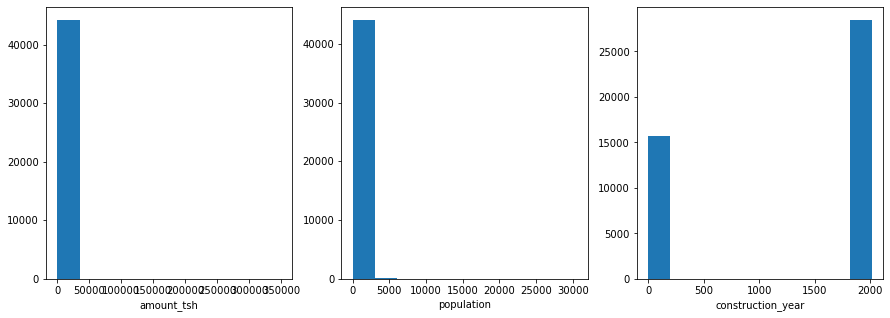

In [44]:
#heavily skewed data, going to input the median for missing values.

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15, 5))

ax1.hist(df['amount_tsh'])
ax1.set_xlabel('amount_tsh')

ax2.hist(df['population'])
ax2.set_xlabel('population')

ax3.hist(df['construction_year'])
ax3.set_xlabel('construction_year')

plt.show()

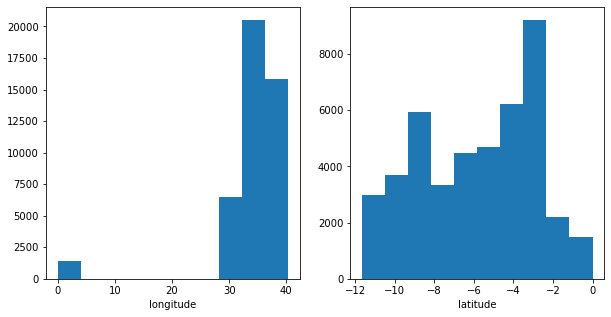

In [45]:
#heavily skewed data
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10, 5))

ax1.hist(df['longitude'])
ax1.set_xlabel('longitude')

ax2.hist(df['latitude'])
ax2.set_xlabel('latitude')
plt.show()

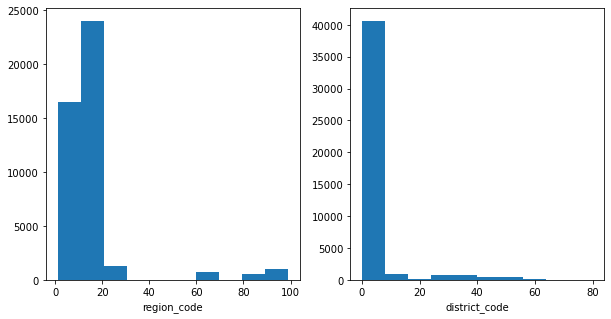

In [46]:
#heavily skewed data, going to input the median for missing values.
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10, 5))

ax1.hist(df['region_code'])
ax1.set_xlabel('region_code')

ax2.hist(df['district_code'])
ax2.set_xlabel('district_code')
plt.show()

In [47]:
#create X and y varaibles and set status_group as the target

X = df.drop(columns = ['status_group'])
y = df['status_group']

X =  X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [48]:
lab_enc = LabelEncoder()
y = lab_enc.fit_transform(y)

In [49]:
#Important to split the data before making any transformations or imputing.
#using the standard 80/20 split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y, random_state = 42)

In [50]:
#sanity check to see how the data has been split
print(X_train.funder.value_counts().sum())
print(X_test.funder.value_counts().sum())

35363
8841


# Building Pipelines

In [51]:
#going to build pipelines to manage data wrangling 

quality_group = [['unknown','fluoride','colored','milky','salty','good']]
quantity = [['unknown','insufficient','dry','seasonal','enough']]                

#using the median since the data is to heavily skewed
numeric_pipeline = Pipeline(steps = [
                           ('numimputer', SimpleImputer(strategy = 'median')),
                           ('numnorm', StandardScaler())])

#categories like water quality, quantity have an order 
ordinal_pipeline1 = Pipeline(steps= [
                            ('ordimputer', SimpleImputer(strategy = 'most_frequent')),
                            ('ordenc', OrdinalEncoder(categories = quality_group)),
                            ('ordnorm', StandardScaler())])

ordinal_pipeline2 = Pipeline(steps=[
                            ('ordimputer', SimpleImputer(strategy = 'most_frequent')),
                            ('ordenc_quantity', OrdinalEncoder(categories = quantity)),
                            ('ordnorm', StandardScaler())])

nominal_pipeline = Pipeline(steps= [
                           ('onehotimputer', SimpleImputer(strategy = 'most_frequent')),
                           ('onehotenc', OneHotEncoder(handle_unknown ='ignore')), 
                           ('onehotnorm', MaxAbsScaler())])

In [52]:
#Specify which column the pipelines will act on. Since I don't have a definitive key for
#the order of quality_group and quantity, I'm going to treat them as categorical variables.

num_cols = df.select_dtypes(['int', 'float']).columns

cat_cols = ['amount_tsh','installer','funder','longitude','latitude','basin','region',
            'region_code','district_code','scheme_management','extraction_type','management',
            'payment','quality_group','quantity','source','waterpoint_type','population',
            'construction_year']

ct = ColumnTransformer([
                        ("nominalpipe", nominal_pipeline, cat_cols),
                        ("numpipe", numeric_pipeline, num_cols)
                       ])

# Logistic Model

In [56]:
#making a baseline logistic regression model. Logistic regression isn't good for multi class
#classification but it's worth seeing how it would do.

LogModel_pipe = Pipeline(steps= [('preproccess', ct),
                                 ('SMOTE', SMOTE(random_state=42)),
                                 ('model', LogisticRegression(solver = 'liblinear'))])

LogModel_pipe.fit(X_train,y_train)

#make predictions
y_hat_train = LogModel_pipe.predict(X_train)
y_hat_pred = LogModel_pipe.predict(X_test)

#score on test data
print('The score of the model is: ',LogModel_pipe.score(X_test,y_test))

The score of the model is:  0.7225426987897297


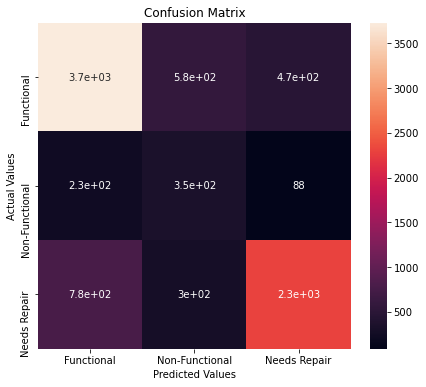

In [59]:
#create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['Functional','Non-Functional','Needs Repair'], 
                     columns = ['Functional','Non-Functional','Needs Repair'])

#Plotting the confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [107]:
with open('LogModel.pickle', 'wb') as f:
    pickle.dump(LogModel_pipe, f)

# Logistic with undersampler

In [86]:
#making a baseline logistic regression model. Logistic regression isn't good for multi class
#classification but it's worth seeing how it would do.

LogModelRandomUndersampler_pipe = Pipeline(steps= [('preproccess', ct),
                                                   ('RandomUnderSampler', RandomUnderSampler(random_state=42)),
                                                   ('model', LogisticRegression(solver = 'liblinear'))])

LogModelRandomUndersampler_pipe.fit(X_train,y_train)

#make predictions
y_hat_train = LogModelRandomUndersampler_pipe.predict(X_train)
y_hat_pred = LogModelRandomUndersampler_pipe.predict(X_test)

#score on test data
print('The score of the model is: ',LogModelRandomUndersampler_pipe.score(X_test,y_test))

The score of the model is:  0.6551295102363986


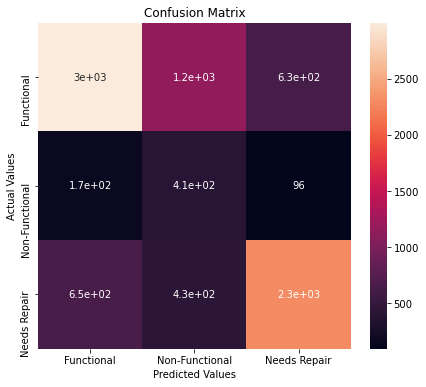

In [87]:
#create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['Functional','Non-Functional','Needs Repair'], 
                     columns = ['Functional','Non-Functional','Needs Repair'])

#Plotting the confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Baseline Desicion Tree Model

In [61]:
#Making a basic desicion tree model. Usually we don't use SMOTE in baseline models but 
#have to here because the data is imbalanced.

BaseTreeModel_pipe = Pipeline(steps= [('preproccess', ct),
                                      ('SMOTE', SMOTE(random_state=42)),
                                      ('model',  DecisionTreeClassifier(criterion='entropy', 
                                                                        random_state = 42))])

BaseTreeModel_pipe.fit(X_train,y_train)

Pipeline(steps=[('preproccess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  ['amount_tsh', 'installer',
                                                   'funder', 'longitude',
                                                   'latitude', 'basin',
                                                   'region', 'region_code',
                                                   'dis

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      4784
           1       0.44      0.37      0.40       676
           2       0.79      0.78      0.78      3381

    accuracy                           0.78      8841
   macro avg       0.68      0.66      0.67      8841
weighted avg       0.77      0.78      0.77      8841

Accuracy is :77.74007465218867


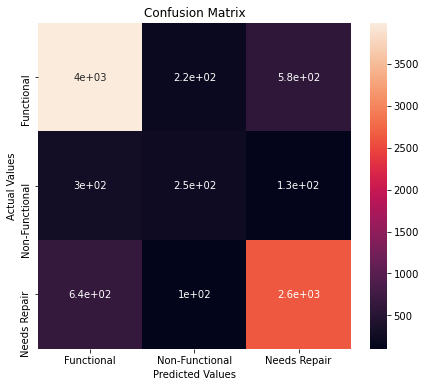

In [62]:
# make predictions
y_pred = BaseTreeModel_pipe.predict(X_test)

# Confusion matrix and classification report
print(classification_report(y_test, y_pred))

# Calculate accuracy 
acc = accuracy_score(y_test, y_pred) * 100
print('Accuracy is :{0}'.format(acc))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Functional','Non-Functional','Needs Repair'], 
                     columns = ['Functional','Non-Functional','Needs Repair'])

#Plotting the confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [125]:
with open('BaseTreeModel.pickle', 'wb') as f:
    pickle.dump(BaseTreeModel_pipe, f)

# Baseline Desicion Tree Model with random under sampler

In [88]:
#Making a basic desicion tree model. Usually we don't use SMOTE in baseline models but 
#have to here because the data is imbalanced.

BaseTreeModelRandom_pipe = Pipeline(steps= [('preproccess', ct),
                                            ('RandomUnderSampler', RandomUnderSampler(random_state=42)),
                                            ('model',  DecisionTreeClassifier(criterion='entropy', 
                                                                        random_state = 42))])

BaseTreeModelRandom_pipe.fit(X_train,y_train)

Pipeline(steps=[('preproccess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  ['amount_tsh', 'installer',
                                                   'funder', 'longitude',
                                                   'latitude', 'basin',
                                                   'region', 'region_code',
                                                   'dis

              precision    recall  f1-score   support

           0       0.81      0.62      0.71      4784
           1       0.24      0.68      0.35       676
           2       0.74      0.71      0.72      3381

    accuracy                           0.66      8841
   macro avg       0.60      0.67      0.59      8841
weighted avg       0.74      0.66      0.68      8841

Accuracy is :65.88621196697207


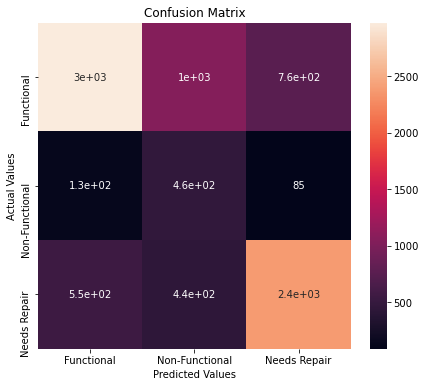

In [89]:
# make predictions
y_pred = BaseTreeModelRandom_pipe.predict(X_test)

# Confusion matrix and classification report
print(classification_report(y_test, y_pred))

# Calculate accuracy 
acc = accuracy_score(y_test, y_pred) * 100
print('Accuracy is :{0}'.format(acc))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Functional','Non-Functional','Needs Repair'], 
                     columns = ['Functional','Non-Functional','Needs Repair'])

#Plotting the confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Tree Model with hyperparameter discovery

In [63]:
# Find the best hyperparameters for tuning the tree
HyperTreeModel_Pipe = Pipeline(steps= [('preproccess', ct),
                                      ('SMOTE', SMOTE(random_state = 42)),
                                      ('tree',  DecisionTreeClassifier(random_state = 42))
                                     ])
 

# Create the grid parameter
grid = [{
        'tree__criterion': ['gini', 'entropy'],
        'tree__max_depth': [2, 6, 10], 
        'tree__min_samples_split': [5, 10]}]


# Create the grid
gridsearch = GridSearchCV(estimator=HyperTreeModel_Pipe, 
                          param_grid=grid, 
                          scoring='accuracy', 
                          cv=3)

In [64]:
# Fit using grid search
gridsearch.fit(X_train, y_train)

# Calculate the test score
print(gridsearch.score(X_test, y_test))

#these parameters are the best for this model
print(gridsearch.best_params_)

#Calculate accuracy 
acc = accuracy_score(y_test, gridsearch.predict(X_test)) * 100
print('Accuracy is :{0}'.format(acc))

0.6774120574595633
{'tree__criterion': 'entropy', 'tree__max_depth': 10, 'tree__min_samples_split': 5}
Accuracy is :67.74120574595634


# Desicion Tree Model with calculated parameters

In [68]:
# Create the pipeline
CalculatedTreeModel_Pipe = Pipeline(steps= [('preproccess', ct),
                                            ('SMOTE', SMOTE()),
                                            ('tree',  DecisionTreeClassifier(random_state = 42))
                                           ])
 
CalculatedTreeModel_Pipe.fit(X_train,y_train)

# Create the grid parameter
grid = [{
        'tree__criterion': ['entropy'],
        'tree__max_depth': [10], 
        'tree__min_samples_split': [5]}]

# Create the grid, with "pipe" as the estimator
gridsearch = GridSearchCV(estimator=CalculatedTreeModel_Pipe, 
                          param_grid=grid, 
                          scoring='accuracy', 
                          cv=2)

# Fit using grid search
gridsearch.fit(X_train, y_train)

# Calculate the test score
print(gridsearch.score(X_test, y_test))

0.6460807600950119


Accuracy is :64.60807600950119


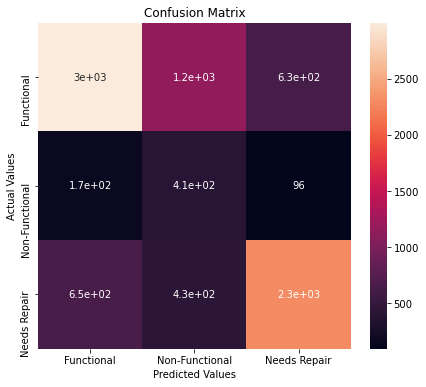

In [69]:
# ct.transform(X_test)
y_pred = gridsearch.predict(X_test)

# Calculate accuracy 
acc = accuracy_score(y_test, y_pred) * 100
print('Accuracy is :{0}'.format(acc))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Functional','Non-Functional','Needs Repair'], 
                     columns = ['Functional','Non-Functional','Needs Repair'])

#Plotting the confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [70]:
with open('CalculatedTreeModel.pickle', 'wb') as f:
    pickle.dump(CalculatedTreeModel_Pipe, f)

# Random Forest 

In [71]:
RandomForest_Pipe = Pipeline(steps= [('preproccess', ct),
                                     ('SMOTE', SMOTE(random_state=42)),
                                     ('tree',  RandomForestClassifier(n_estimators=100, max_depth= 5, random_state = 42))
                                    ])


# Create the grid, with "pipe" as the estimator
gridsearch = GridSearchCV(estimator=RandomForest_Pipe, 
                          param_grid=grid, 
                          scoring='accuracy', 
                          cv=3)

# Fit using grid search
gridsearch.fit(X_train, y_train)

# Calculate the test score
print(gridsearch.score(X_test, y_test))


0.6150887908607624


Accuracy is :61.50887908607624


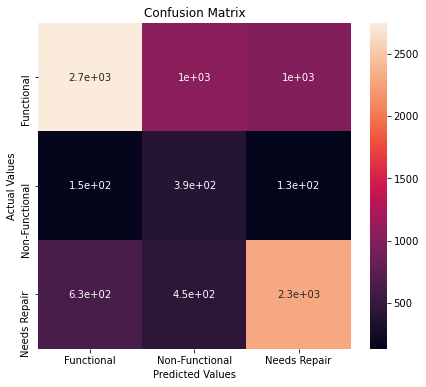

In [152]:
# ct.transform(X_test)
y_pred = gridsearch.predict(X_test)

# Calculate accuracy 
acc = accuracy_score(y_test, y_pred) * 100
print('Accuracy is :{0}'.format(acc))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Functional','Non-Functional','Needs Repair'], 
                     columns = ['Functional','Non-Functional','Needs Repair'])

#Plotting the confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [153]:
# Complete the function
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average='weighted')))
    print("Recall Score: {}".format(recall_score(labels, preds, average='weighted')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    
print_metrics(y_test, test_preds)

Precision Score: 0.6931761428910805
Recall Score: 0.6150887908607624
Accuracy Score: 0.6150887908607624


In [154]:
with open('RandomForest.pickle', 'wb') as f:
    pickle.dump(RandomForest_Pipe, f)

# KNN Model

In [72]:
# Create the pipeline
KnnModel_Pipe = Pipeline(steps= [('preproccess', ct),
                                ('SMOTE', SMOTE()),
                                ('Knn',  KNeighborsClassifier())
                                ])

# Fit the pipeline
KnnModel_Pipe.fit(X_train,y_train)

# Predict on the test set
y_preds = KnnModel_Pipe.predict(X_test)

Accuracy is :64.60807600950119


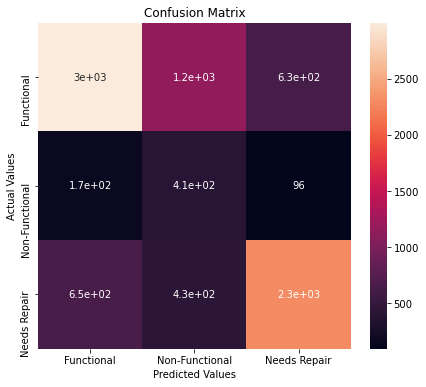

In [73]:
# Calculate accuracy 
acc = accuracy_score(y_test, y_pred) * 100
print('Accuracy is :{0}'.format(acc))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Functional','Non-Functional','Needs Repair'], 
                     columns = ['Functional','Non-Functional','Needs Repair'])

#Plotting the confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [75]:
# Complete the function
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average='weighted')))
    print("Recall Score: {}".format(recall_score(labels, preds, average='weighted')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    
print_metrics(y_test, y_pred)

Precision Score: 0.7312454904037896
Recall Score: 0.6460807600950119
Accuracy Score: 0.6460807600950119


In [145]:
with open('KnnModelModel.pickle', 'wb') as f:
    pickle.dump(KnnModel_Pipe, f)

# XGboost Model

In [76]:
# Create the pipeline
XgbModel_Pipe = Pipeline(steps= [('preproccess', ct),
                                  ('SMOTE', SMOTE(random_state = 42)),
                                  ('tree',  XGBClassifier())
                                ])
# Fit XGBClassifier
XgbModel_Pipe.fit(X_train,y_train)

# Predict on training and test sets
training_preds = XgbModel_Pipe.predict(X_train)
test_preds = XgbModel_Pipe.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 79.6%
Validation accuracy: 77.06%


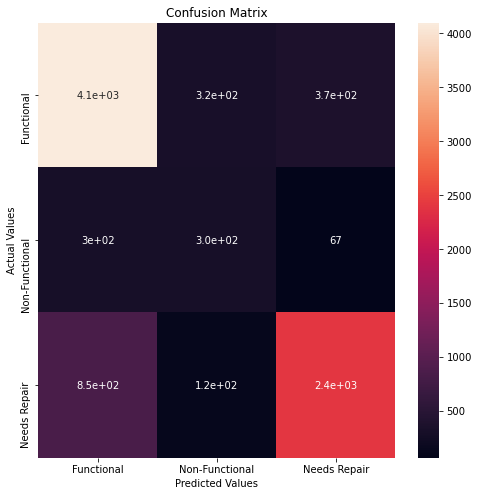

In [77]:
cm = confusion_matrix(y_test, test_preds)
cm_df = pd.DataFrame(cm,
                     index = ['Functional','Non-Functional','Needs Repair'], 
                     columns = ['Functional','Non-Functional','Needs Repair'])

#Plotting the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [150]:
with open('XgbModel.pickle', 'wb') as f:
           pickle.dump(XgbModel_Pipe, f)

# Tuning XGboost

In [78]:
# Create the pipeline
XgbModel_Pipe = Pipeline(steps= [('preproccess', ct),
                                 ('SMOTE', SMOTE()),
                                 ('tree',  XGBClassifier())
                                ])

#parameter tuning 
grid = {
        'tree__learning_rate': [0.1, 0.2],
        'tree__max_depth': [6],
        'tree__min_child_weight': [1, 2],
        'tree__subsample': [0.5, 0.7],
        'tree__n_estimators': [100],
}

# Create the grid, with "pipe" as the estimator
gridsearch = GridSearchCV(estimator=XgbModel_Pipe, 
                          param_grid=grid, 
                          scoring='accuracy', 
                          cv=3)

# Fit using grid search
gridsearch.fit(X_train, y_train)

# Predict on training and test sets
training_preds = gridsearch.predict(X_train)
test_preds = gridsearch.predict(X_test)

In [79]:
# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 78.77%
Validation accuracy: 76.65%


In [87]:
#get the values for the best estimators 
gridsearch.best_estimator_.named_steps['preproccess'].transformers_[0][1]['onehotenc'].get_feature_names()

array(['x0_0.0', 'x0_0.25', 'x0_1.0', ..., 'x18_2011', 'x18_2012',
       'x18_2013'], dtype=object)

In [80]:
with open('TunedXgbModel.pickle', 'wb') as f:
           pickle.dump(XgbModel_Pipe, f)